# Calibration of HBV model for Leven at Newby Bridge using eWaterCycle
This notebook uses eWaterCycle to calibrate the HBV model. It is assumed you have seen [this](link) notebook that shows how to run a single model.

First we repeat the cells for setting up a single model: paths, region and forcing.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import shutil

#general python
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Choose region
See the documentation on the single model notebook

In [3]:
camelsgb_id = "camelsgb_73010"

## set up paths

In [4]:
forcing_path = Path.home() / "Forcing"
forcing_path.mkdir(exist_ok=True)

forcing_path_basin = forcing_path / camelsgb_id 
forcing_path_basin.mkdir(exist_ok=True)

forcing_path_caravan = forcing_path_basin / "caravan"
forcing_path_caravan.mkdir(exist_ok=True)

prepared_forcing_path_caravan_user = forcing_path_basin / "caravan-prepared"
prepared_forcing_path_caravan_user.mkdir(exist_ok=True)

prepared_forcing_path_caravan_central = Path("/data/eurocsdms-storage/forcing/camelsgb_73010/caravan")
shutil.copytree(prepared_forcing_path_caravan_central, prepared_forcing_path_caravan_user, dirs_exist_ok=True)

forcing_path_ERA5 = forcing_path_basin / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

prepared_forcing_path_ERA5_user = forcing_path_basin / "ERA5-prepared"

prepared_forcing_path_ERA5_central = Path("/data/eurocsdms-storage/forcing/camelsgb_73010/ERA5")
shutil.copytree(prepared_forcing_path_ERA5_central / "work", prepared_forcing_path_ERA5_user / "work", dirs_exist_ok=True)

PosixPath('/home/rhut/Forcing/camelsgb_73010/ERA5-prepared/work')

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
calibration_start_date = "1997-08-01T00:00:00Z"
calibration_end_date = "2000-08-31T00:00:00Z"


## Forcing
See the documentation on the single model notebook

In [6]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(start_time = experiment_start_date,
#                                                                end_time = experiment_end_date,
#                                                                directory = forcing_path_caravan,
#                                                                basin_id = camelsgb_id,
#                                                                  )

# # option two: load data you generated yourself
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory = forcing_path_caravan)

# option three: load data someone else generated 
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory = prepared_forcing_path_caravan_user)

In [7]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan-prepared'),
    shape=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan-prepared/camelsgb_73010.shp'),
    filenames={
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc'
    }
)

In [8]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan-prepared'),
    shape=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan-prepared/camelsgb_73010.shp'),
    filenames={
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc'
    }
)

<Axes: xlabel='time'>

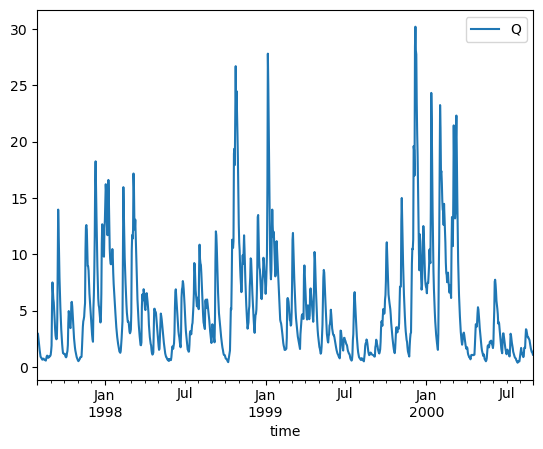

In [9]:
ds = xr.open_dataset(camelsgb_forcing['Q'])
caravan_observation_df = ds['Q'].to_dataframe().reset_index()
caravan_observation_df = caravan_observation_df.set_index('time')
caravan_observation_df = caravan_observation_df[['Q']] #NOTE: mm/day
caravan_observation_df.plot()

In [10]:
ERA5_forcing_dir = forcing_path / camelsgb_id / "ERA5"

In [11]:
# # option one: generate forcing:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
#    directory=forcing_path_ERA5
# )

# # option two: load data you generated yourself
# load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script" #this is needed because ERA5 forcing data is stored deep in a sub-directory
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

# option three: load data someone else generated for you
load_location = prepared_forcing_path_ERA5_user / "work" / "diagnostic" / "script" #this is needed because ERA5 forcing data is stored deep in a sub-directory
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

## Create a collection of parameter sets
We will be running the model a thousand time, each with a different set of parameters, to find the best combination of parameters possible. First we will create arrays to hold these parameters. It is important to limit the range per parameter.

Using just random sampling is not the smartest strategy in calibrating hydrological models, but is presented here for simplicty.

In [12]:
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

In [13]:
#The number of ensemble members in our ensemble
N = 1000

## Array of parameters min/max bounds 
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])

#create empty array to fill 
parameters = np.zeros([len(p_min_initial), N])

#fill with random values bounded by the min and max given above.
for param in range(len(p_min_initial)):
    parameters[param,:] = np.random.uniform(p_min_initial[param],p_max_initial[param],N)


Just as with the normal model run, we need a set of initial storages: <br>
                Si,  Su, Sf, Ss


In [14]:
s_0 = np.array([0,  100,  0,  5, 0])

## Objective function for calibration
We need to compare the output of the model to observations and come up with a "score" to indicate how 'fit' the combination of parameters is. Here we define a function that takes in two data frames and compares the timeseries in those and returns a root-mean-square value. Other objective functions can be defined of course.

In [15]:
def calibrationObjective(modelOutput,observation,start_calibration,end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference

    diff = hydro_data['Q'] - hydro_data['model output']
    rms = np.sqrt(np.mean(diff**2))

    return rms
  

## Setting up an ensemble of models
Since models are objects in eWaterCycle, arrays of models can be created, making it easy to start a lot of models with roughly the same settings. The one major difference in starting the models is that a specific configuration directory is provided, because otherwise multiple models might end up with the same config file name, because it is timestamp based.

A new development is that an extension of eWaterCycle is near completion called eWaterCycle Data Assimilation (ewatercycle.da), which includes ensembles of models as a native concept and makes running ensemble members in parallel easier.

In [16]:
from ewatercycle_HBV.model import HBVLocal

In [17]:
ensemble = []

for counter in range(N):

    #add a model to the ensemble
    ensemble.append(HBVLocal(forcing=ERA5_forcing))

for counter in range(N):

    #create the config_file for this specific model, make sure the right parameters get passed
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "/home/rhut/configFiles/" + camelsgb_id + "_hbv_ensembleMember_" + str(counter),
                               )

    #use this config file to initialize this ensemble member
    ensemble[counter].initialize(config_file)


In [18]:
counter

999

## Run all the models
Here we run all the models, one by one, and calculate and save the value of the objective function for this ensemble member.

For more complex models, this loop can easily be run in parallel. Here we keep it simple. We do add a progressbar to indicate things are happening.

In [19]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q") #* Caravan_observations_area[caravan_basin_id] / (1000 * 86400)
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))
    
    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,caravan_observation_df,calibration_start_date,calibration_end_date)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model

    #update progress bar
    f.value += 1

    ensembleMember.finalize()

IntProgress(value=0, max=1000)

## Save and display results
We make a plot for each parameter to show how they score on the objective function over the range provided. We print out the combination of parameters with the lowest objective function and we save those values to a csv file to read in the other notebook.

[4.20338243e+00 5.59031863e-01 7.20736361e+01 2.15099457e+00
 2.34657056e-01 5.19139962e+00 5.49124942e-02 3.29736399e-03
 4.29809398e+00]

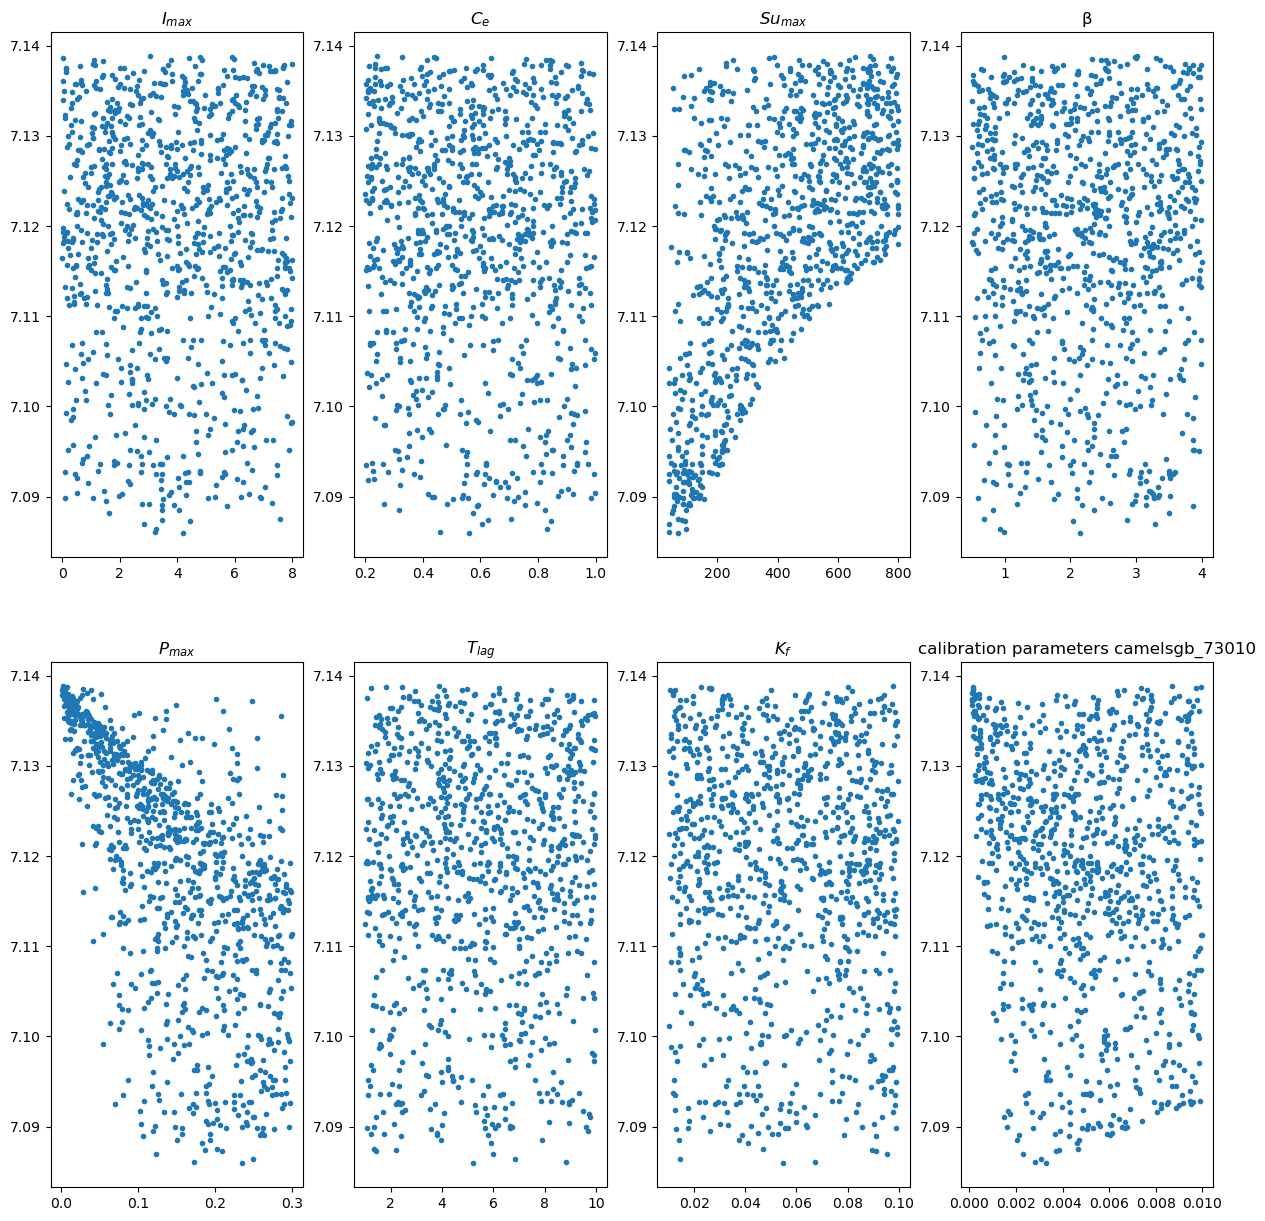

In [20]:
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])
plt.title('calibration parameters ' + camelsgb_id)
plt.savefig('/home/rhut/figures/calibration parameters ' + camelsgb_id + '.png')

parameters_minimum_index = np.argmin(np.array(objectives))
parameters_minimum = parameters[:,parameters_minimum_index]
np.savetxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", parameters_minimum, delimiter=",")
print(parameters_minimum)

